<a href="https://colab.research.google.com/github/Minhvt34/cbm_codes_open/blob/master/BayesianLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install blitz-bayesian-pytorch

     |████████████████████████████████| 48 kB 2.6 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import  torch.optim as optim
import torch.nn.functional as F

from blitz.modules import BayesianLSTM
from blitz.utils import variational_estimator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
#matplotlib inline

from collections import deque

In [ ]:
col_names = ['b1_ch1', 'b1_ch2', 'b2_ch3', 'b2_ch4', 'b3_ch5', 'b3_ch6', 'b4_ch7', 'b4_ch8']
df = pd.read_csv('/content/drive/MyDrive/2003.10.22.12.06.24', sep='\t', names=col_names)
df["Date"] = pd.date_range('1/1/2011', periods = 20480, freq ='H')

window_size = 21

print(df.head())

close_prices = df["b1_ch1"]
scaler = StandardScaler()

close_prices_arr = np.array(close_prices).reshape(-1, 1)
close_prices = scaler.fit_transform(close_prices_arr)

close_prices_unscaled = df["b1_ch1"]

   b1_ch1  b1_ch2  b2_ch3  b2_ch4  b3_ch5  b3_ch6  b4_ch7  b4_ch8  \
0  -0.022  -0.039  -0.183  -0.054  -0.105  -0.134  -0.129  -0.142   
1  -0.105  -0.017  -0.164  -0.183  -0.049   0.029  -0.115  -0.122   
2  -0.183  -0.098  -0.195  -0.125  -0.005  -0.007  -0.171  -0.071   
3  -0.178  -0.161  -0.159  -0.178  -0.100  -0.115  -0.112  -0.078   
4  -0.208  -0.129  -0.261  -0.098  -0.151  -0.205  -0.063  -0.066   

                 Date  
0 2011-01-01 00:00:00  
1 2011-01-01 01:00:00  
2 2011-01-01 02:00:00  
3 2011-01-01 03:00:00  
4 2011-01-01 04:00:00  


In [ ]:
def create_timestamps_ds(series,
                         timestep_size=window_size):
    time_stamps = []
    labels = []
    aux_deque = deque(maxlen=timestep_size)

    # starting the timestep deque
    for i in range(timestep_size):
        aux_deque.append(0)

    # feed the timestamps list
    for i in range(len(series) - 1):
        aux_deque.append(series[i])
        time_stamps.append(list(aux_deque))

    # feed the labels lsit
    for i in range(len(series) - 1):
        labels.append(series[i + 1])

    assert len(time_stamps) == len(labels), "Something went wrong"

    # torch-tensoring it
    features = torch.tensor(time_stamps[timestep_size:]).float()
    labels = torch.tensor(labels[timestep_size:]).float()

    return features, labels

In [ ]:
@variational_estimator
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.lstm_1 = BayesianLSTM(1, 10, prior_sigma_1=1, prior_pi=1, posterior_rho_init=-3.0)
        self.linear = nn.Linear(10, 1)

    def forward(self, x):
        x_, _ = self.lstm_1(x)

        # gathering only the latent end-of-sequence for the linear layer
        x_ = x_[:, -1, :]
        x_ = self.linear(x_)
        return x_

In [ ]:
Xs, ys = create_timestamps_ds(close_prices)
X_train, X_test, y_train, y_test = train_test_split(Xs,
                                                    ys,
                                                    test_size=.25,
                                                    random_state=42,
                                                    shuffle=False)



ds = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)

net = NN()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

iteration = 0
for epoch in range(10):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()

        loss = net.sample_elbo(inputs=datapoints,
                               labels=labels,
                               criterion=criterion,
                               sample_nbr=3,
                               complexity_cost_weight=1 / X_train.shape[0])
        loss.backward()
        optimizer.step()

        iteration += 1
        if iteration % 250 == 0:
            preds_test = net(X_test)[:, 0].unsqueeze(1)
            loss_test = criterion(preds_test, y_test)
            print("Iteration: {} Val-loss: {:.4f}".format(str(iteration), loss_test))

#pred_unscaled
original = close_prices_unscaled[1:][window_size:]
df_pred = pd.DataFrame(original)
df_pred["Date"] = df.Date
df["Date"] = pd.to_datetime(df_pred["Date"])
df_pred = df_pred.reset_index()

Iteration: 250 Val-loss: 0.6476
Iteration: 500 Val-loss: 0.5950
Iteration: 750 Val-loss: 0.5113
Iteration: 1000 Val-loss: 0.5152
Iteration: 1250 Val-loss: 0.4924
Iteration: 1500 Val-loss: 0.4818
Iteration: 1750 Val-loss: 0.4845
Iteration: 2000 Val-loss: 0.4848
Iteration: 2250 Val-loss: 0.4689
Iteration: 2500 Val-loss: 0.4762
Iteration: 2750 Val-loss: 0.4721
Iteration: 3000 Val-loss: 0.4759
Iteration: 3250 Val-loss: 0.4930
Iteration: 3500 Val-loss: 0.4892
Iteration: 3750 Val-loss: 0.4690
Iteration: 4000 Val-loss: 0.4636
Iteration: 4250 Val-loss: 0.4549
Iteration: 4500 Val-loss: 0.4682
Iteration: 4750 Val-loss: 0.4585
Iteration: 5000 Val-loss: 0.4811
Iteration: 5250 Val-loss: 0.4766
Iteration: 5500 Val-loss: 0.4883
Iteration: 5750 Val-loss: 0.4548
Iteration: 6000 Val-loss: 0.4933
Iteration: 6250 Val-loss: 0.4543
Iteration: 6500 Val-loss: 0.4869
Iteration: 6750 Val-loss: 0.4588
Iteration: 7000 Val-loss: 0.4548
Iteration: 7250 Val-loss: 0.4608
Iteration: 7500 Val-loss: 0.4722
Iteration: 77

In [ ]:
def pred_stock_future(X_test,
                      future_length,
                      sample_nbr=10):
    # sorry for that, window_size is a global variable, and so are X_train and Xs
    global window_size
    global X_train
    global Xs
    global scaler

    # creating auxiliar variables for future prediction
    preds_test = []
    test_begin = X_test[0:1, :, :]
    test_deque = deque(test_begin[0, :, 0].tolist(), maxlen=window_size)

    idx_pred = np.arange(len(X_train), len(Xs))

    # predict it and append to list
    for i in range(len(X_test)):
        # print(i)
        as_net_input = torch.tensor(test_deque).unsqueeze(0).unsqueeze(2)
        pred = [net(as_net_input).cpu().item() for i in range(sample_nbr)]

        test_deque.append(torch.tensor(pred).mean().cpu().item())
        preds_test.append(pred)

        if i % future_length == 0:
            # our inptus become the i index of our X_test
            # That tweak just helps us with shape issues
            test_begin = X_test[i:i + 1, :, :]
            test_deque = deque(test_begin[0, :, 0].tolist(), maxlen=window_size)

    # preds_test = np.array(preds_test).reshape(-1, 1)
    # preds_test_unscaled = scaler.inverse_transform(preds_test)

    return idx_pred, preds_test

In [ ]:
def get_confidence_intervals(preds_test, ci_multiplier):
    global scaler

    preds_test = torch.tensor(preds_test)

    pred_mean = preds_test.mean(1)
    pred_std = preds_test.std(1).detach().cpu().numpy()

    pred_std = torch.tensor((pred_std))
    # print(pred_std)

    upper_bound = pred_mean + (pred_std * ci_multiplier)
    lower_bound = pred_mean - (pred_std * ci_multiplier)
    # gather unscaled confidence intervals

    pred_mean_final = pred_mean.unsqueeze(1).detach().cpu().numpy()
    pred_mean_unscaled = scaler.inverse_transform(pred_mean_final)

    upper_bound_unscaled = upper_bound.unsqueeze(1).detach().cpu().numpy()
    upper_bound_unscaled = scaler.inverse_transform(upper_bound_unscaled)

    lower_bound_unscaled = lower_bound.unsqueeze(1).detach().cpu().numpy()
    lower_bound_unscaled = scaler.inverse_transform(lower_bound_unscaled)

    return pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled

In [ ]:
future_length=5
sample_nbr=4
ci_multiplier=5
idx_pred, preds_test = pred_stock_future(X_test, future_length, sample_nbr)
pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled = get_confidence_intervals(preds_test,
                                                                                          ci_multiplier)
y = np.array(df.b1_ch1[-5115:]).reshape(-1, 1)
under_upper = upper_bound_unscaled > y
over_lower = lower_bound_unscaled < y
total = (under_upper == over_lower)

print("{} our predictions are in our confidence interval".format(np.mean(total)))

0.39589442815249265 our predictions are in our confidence interval


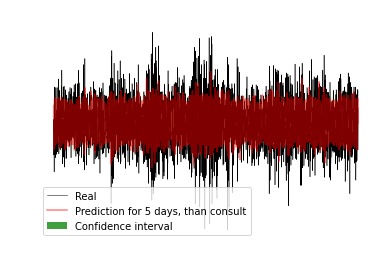

In [ ]:
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

plt.title("IBM Stock prices", color="white")


plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.75)

plt.plot(idx_pred,
         df_pred.b1_ch1[-len(pred_mean_unscaled):],
         label="Real",
         alpha=1,
         color='black',
         linewidth=0.5)

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, than consult".format(future_length),
         color="red",
         alpha=0.5)

plt.legend()

plt.show()

In [ ]:
import dba

In [ ]:
import utils

In [ ]:
import numpy as np 
import pandas as pd 
import os
import matplotlib 
matplotlib.use('pdf')
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder

import operator
from scipy.stats import wilcoxon


def zNormalize(x):
    x_mean = x.mean(axis=0) # mean for each dimension of time series x
    x_std = x.std(axis = 0) # std for each dimension of time series x
    x = (x - x_mean)/(x_std)
    return x

def readucr(filename):
    data = np.loadtxt(filename, delimiter = ',')
    Y = data[:,0]
    X = data[:,1:]
    return X, Y

def check_if_file_exits(file_name):
    return os.path.exists(file_name)

def create_directory(directory_path): 
    if os.path.exists(directory_path):
        return None
    else: 
        try: 
            os.makedirs(directory_path)
        except:
            # in case another machine created the path meanwhile
            return None
        return directory_path

def transform_labels(y_train,y_test):
    """
    Transform label to min equal zero and continuous 
    For example if we have [1,3,4] --->  [0,1,2]
    """
    # init the encoder
    encoder = LabelEncoder()
    # concat train and test to fit 
    y_train_test = np.concatenate((y_train,y_test),axis =0)
    # fit the encoder 
    encoder.fit(y_train_test)
    # transform to min zero and continuous labels 
    new_y_train_test = encoder.transform(y_train_test)
    # resplit the train and test
    new_y_train = new_y_train_test[0:len(y_train)]
    new_y_test = new_y_train_test[len(y_train):]
    return new_y_train, new_y_test    

def read_all_datasets(root_dir,archive_name, sort_dataset_name = False):
    datasets_dict = {}

    dataset_names_to_sort = []
    
    for dataset_name in DATASET_NAMES: 
        file_name = root_dir+archive_name+'/'+dataset_name+'/'+dataset_name
        x_train, y_train = readucr(file_name+'_TRAIN')
        x_test, y_test = readucr(file_name+'_TEST')
        datasets_dict[dataset_name] = (x_train.copy(),y_train.copy(),x_test.copy(),y_test.copy())
        dataset_names_to_sort.append((dataset_name,len(x_train)))
    
    item_getter = 1
    if sort_dataset_name == True: 
        item_getter = 0
    dataset_names_to_sort.sort(key=operator.itemgetter(item_getter))
    
    for i in range(len(DATASET_NAMES)):
        DATASET_NAMES[i] = dataset_names_to_sort[i][0]
    
    return datasets_dict

def calculate_metrics(y_true, y_pred,duration,clustering=False):
    """
    Return a data frame that contains the precision, accuracy, recall and the duration
    For clustering it applys the adjusted rand index
    """
    if clustering == False:
        res = pd.DataFrame(data = np.zeros((1,5),dtype=np.float), index=[0], 
            columns=['precision','accuracy','error','recall','duration'])
        res['precision'] = precision_score(y_true,y_pred,average='macro')
        res['accuracy'] = accuracy_score(y_true,y_pred)
        res['recall'] = recall_score(y_true,y_pred,average='macro')
        res['duration'] = duration
        res['error'] = 1-res['accuracy']
        return res
    else: 
        res = pd.DataFrame(data = np.zeros((1,2),dtype=np.float), index=[0], 
            columns=['ari','duration'])
        res['duration']=duration
        res['ari'] = adjusted_rand_score(y_pred,y_true)
        return res

def dataset_is_ready_to_plot(df_res,dataset_name,archive_name,array_algorithm_names):
    for algorithm_name in array_algorithm_names:
                # if any algorithm algorithm is not finished do not plot 
                if not any(df_res.loc[(df_res['dataset_name']==dataset_name) \
                            & (df_res['archive_name']==archive_name)] \
                            ['algorithm_name']==algorithm_name)\
                                       or (df_res.loc[(df_res['dataset_name']==dataset_name) \
                            & (df_res['archive_name']==archive_name)\
                            & (df_res['algorithm_name']==algorithm_name)]\
                                       ['nb_prototypes'].max()!=MAX_PROTOTYPES_PER_CLASS):
                    return False
    return True

def init_empty_df_metrics():
    return pd.DataFrame(data = np.zeros((0,5),dtype=np.float), index=[], 
        columns=['precision','accuracy','error','recall','duration'])

def get_df_metrics_from_avg(avg_df_metrics):
    res = pd.DataFrame(data = np.zeros((1,5),dtype=np.float), index=[0], 
        columns=['precision','accuracy','error','recall','duration'])
    res['accuracy'] = avg_df_metrics['accuracy'].mean()
    res['precision'] = avg_df_metrics['precision'].mean()
    res['error'] = avg_df_metrics['error'].mean()
    res['recall'] = avg_df_metrics['recall'].mean()
    res['duration'] = avg_df_metrics['duration'].mean()
    return res

def get_df_metrics_from_avg_data_cluster(avg_df_metrics):
    res = pd.DataFrame(data = np.zeros((1,2),dtype=np.float), index=[0],
        columns=['ari','duration'])
    res['ari'] = avg_df_metrics['ari'].mean()
    res['duration'] = avg_df_metrics['duration'].mean()
    return res

def read_dataset(root_dir,archive_name,dataset_name):
    datasets_dict = {}

    file_name = root_dir+'/'+archive_name+'/'+dataset_name+'/'+dataset_name
    x_train, y_train = readucr(file_name+'_TRAIN')
    x_test, y_test = readucr(file_name+'_TEST')
    datasets_dict[dataset_name] = (x_train.copy(),y_train.copy(),x_test.copy(),
        y_test.copy())

    return datasets_dict

def plot_epochs_metric(hist, file_name, metric='loss'):
    plt.figure()
    plt.plot(hist.history[metric])
    plt.plot(hist.history['val_'+metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(file_name)
    plt.close()

def save_logs(output_directory, hist, y_pred, y_true,duration ):
    hist_df = pd.DataFrame(hist.history)
    hist_df.to_csv(output_directory+'history.csv', index=False)

    df_metrics = calculate_metrics(y_true,y_pred, duration)
    df_metrics.to_csv(output_directory+'df_metrics.csv', index=False)

    index_best_model = hist_df['loss'].idxmin() 
    row_best_model = hist_df.loc[index_best_model]

    df_best_model = pd.DataFrame(data = np.zeros((1,6),dtype=np.float) , index = [0], 
        columns=['best_model_train_loss', 'best_model_val_loss', 'best_model_train_acc', 
        'best_model_val_acc', 'best_model_learning_rate','best_model_nb_epoch'])
    
    df_best_model['best_model_train_loss'] = row_best_model['loss']
    df_best_model['best_model_val_loss'] = row_best_model['val_loss']
    df_best_model['best_model_train_acc'] = row_best_model['acc']
    df_best_model['best_model_val_acc'] = row_best_model['val_acc']
    df_best_model['best_model_learning_rate'] = row_best_model['lr']
    df_best_model['best_model_nb_epoch'] = index_best_model

    df_best_model.to_csv(output_directory+'df_best_model.csv', index=False)

    # for FCN there is no hyperparameters fine tuning - everything is static in code 

    # plot losses 
    plot_epochs_metric(hist, output_directory+'epochs_loss.png')

# visualizations pairwise plots for AALTD 2018

def generate_results_csv(output_file_name, root_dir,root_dir_dataset_archive, add_bake_off=True):
    res = pd.DataFrame(data=np.zeros((0, 7), dtype=np.float), index=[],
                       columns=['classifier_name', 'archive_name', 'dataset_name',
                                'precision', 'accuracy', 'recall', 'duration'])
    CLASSIFIERS = ['resnet','resnet_augment','ensemble']
    ITERATIONS = 1
    for classifier_name in CLASSIFIERS:
        for archive_name in ARCHIVE_NAMES:
            datasets_dict = read_all_datasets(root_dir_dataset_archive, archive_name)
            for it in range(ITERATIONS):
                curr_archive_name = archive_name
                if it != 0:
                    curr_archive_name = curr_archive_name + '_itr_' + str(it)
                for dataset_name in datasets_dict.keys():
                    output_dir = root_dir + '/results/' + classifier_name + '/' \
                                 + curr_archive_name + '/' + dataset_name + '/' + 'df_metrics.csv'
                    if not os.path.exists(output_dir):
                        continue
                    df_metrics = pd.read_csv(output_dir)
                    df_metrics['classifier_name'] = classifier_name
                    df_metrics['archive_name'] = archive_name
                    df_metrics['dataset_name'] = dataset_name
                    res = pd.concat((res, df_metrics), axis=0, sort=False)

    res.to_csv(root_dir + output_file_name, index=False)
    # aggreagte the accuracy for iterations on same dataset
    res = pd.DataFrame({
        'accuracy': res.groupby(
            ['classifier_name', 'archive_name', 'dataset_name'])['accuracy'].mean()
    }).reset_index()

    return res

def plot_pairwise(root_dir,root_dir_dataset_archive, classifier_name_1, classifier_name_2,
                  res_df=None, title='', fig=None, color='green', label=None):
    if fig is None:
        plt.figure()
    else:
        plt.figure(fig)

    if res_df is None:
        res_df = generate_results_csv('results.csv', root_dir,root_dir_dataset_archive)

    sorted_df = res_df.loc[(res_df['classifier_name'] == classifier_name_1) | \
                           (res_df['classifier_name'] == classifier_name_2)]. \
        sort_values(['classifier_name', 'archive_name', 'dataset_name'])
    # number of classifier we are comparing is 2 since pairwise
    m = 2
    # get max nb of ready datasets
    # count the number of tested datasets per classifier
    df_counts = pd.DataFrame({'count': sorted_df.groupby(
        ['classifier_name']).size()}).reset_index()
    # get the maximum number of tested datasets
    max_nb_datasets = df_counts['count'].max()
    min_nb_datasets = df_counts['count'].min()
    # both classifiers should have finished
    assert (max_nb_datasets == min_nb_datasets)

    data = np.array(sorted_df['accuracy']).reshape(m, max_nb_datasets).transpose()

    # concat the dataset name and the archive name to put them in the columns s
    sorted_df['archive_dataset_name'] = sorted_df['archive_name'] + '__' + \
                                        sorted_df['dataset_name']
    # create the data frame containg the accuracies
    df_data = pd.DataFrame(data=data, columns=np.sort([classifier_name_1, classifier_name_2]),
                           index=np.unique(sorted_df['archive_dataset_name']))

    # # assertion
    # p1 = float(sorted_df.loc[(sorted_df['classifier_name'] == classifier_name_1) &
    #                          (sorted_df['dataset_name'] == 'Beef')]['accuracy'])
    # p2 = float(df_data[classifier_name_1]['UCR_TS_Archive_2015__Beef'])
    # assert (p1 == p2)

    x = np.arange(start=0, stop=1, step=0.01)
    plt.xlim(xmax=1.02, xmin=0.0)
    plt.ylim(ymax=1.02, ymin=0.0)

    plt.scatter(x=df_data[classifier_name_1], y=df_data[classifier_name_2], color='blue')
    # c=sorted_df['theme_colors'])
    plt.xlabel('without data augmentation', fontsize='large')
    plt.ylabel('with data augmentation', fontsize='large')
    plt.plot(x, x, color='black')
    # plt.legend(loc='upper left')
    plt.title(title)

    uniq, counts = np.unique(df_data[classifier_name_1] < df_data[classifier_name_2], return_counts=True)
    print('Wins', counts[-1])

    uniq, counts = np.unique(df_data[classifier_name_1] == df_data[classifier_name_2], return_counts=True)
    print('Draws', counts[-1])

    uniq, counts = np.unique(df_data[classifier_name_1] > df_data[classifier_name_2], return_counts=True)
    print('Losses', counts[-1])

    p_value = wilcoxon(df_data[classifier_name_1], df_data[classifier_name_2], zero_method='pratt')[1]
    print(p_value)

    plt.savefig(root_dir + '/' + classifier_name_1 + '-' + classifier_name_2 + '_' + title + '.pdf'
                , bbox_inches='tight')

In [ ]:
import keras
import numpy as np
import gc

class Classifier_ENSEMBLE:
    def __init__(self, output_directory, input_shape, nb_classes, verbose=False):
        self.output_directory = output_directory
        self.model1 = keras.models.load_model(self.output_directory.
                                    replace('ensemble','resnet')
                                    +'best_model.hdf5')
        self.model2 = keras.models.load_model(self.output_directory.
                                    replace('ensemble','resnet_augment')
                                    +'best_model.hdf5')
        if (verbose == True):
            self.model1.summary()
            self.model2.summary()
        self.verbose = verbose

    def fit(self, x_test, y_true):
        # no training since models are pre-trained

        y_pred1 = self.model1.predict(x_test)
        y_pred2 = self.model2.predict(x_test)

        y_pred = (y_pred1+y_pred2)/2

        # convert the predicted from binary to integer
        y_pred = np.argmax(y_pred, axis=1)

        df_metrics = calculate_metrics(y_true, y_pred, 0.0)

        df_metrics.to_csv(self.output_directory+'df_metrics.csv', index=False)

        keras.backend.clear_session()

        gc.collect()

In [ ]:
!pip install dtw-python

     |████████████████████████████████| 580 kB 5.3 MB/s 


In [ ]:
from dba import dba

from dtw import *

from augment import get_weights_average_selected

DATASET_NAMES = ['50words','Adiac','ArrowHead','Beef','BeetleFly',
                            'BirdChicken','Car','CBF','ChlorineConcentration',
                            'CinC_ECG_torso','Coffee','Computers','Cricket_X',
                            'Cricket_Y','Cricket_Z','DiatomSizeReduction',
                            'DistalPhalanxOutlineAgeGroup',
                            'DistalPhalanxOutlineCorrect','DistalPhalanxTW',
                            'Earthquakes','ECG200','ECG5000','ECGFiveDays',
                            'ElectricDevices','FaceAll','FaceFour','FacesUCR',
                            'FISH','FordA','FordB','Gun_Point','Ham',
                            'HandOutlines','Haptics','Herring','InlineSkate',
                            'InsectWingbeatSound','ItalyPowerDemand',
                            'LargeKitchenAppliances','Lighting2','Lighting7',
                            'MALLAT','Meat','MedicalImages',
                            'MiddlePhalanxOutlineAgeGroup',
                            'MiddlePhalanxOutlineCorrect','MiddlePhalanxTW',
                            'MoteStrain','NonInvasiveFatalECG_Thorax1',
                            'NonInvasiveFatalECG_Thorax2','OliveOil','OSULeaf',
                            'PhalangesOutlinesCorrect','Phoneme','Plane',
                            'ProximalPhalanxOutlineAgeGroup',
                            'ProximalPhalanxOutlineCorrect',
                            'ProximalPhalanxTW','RefrigerationDevices',
                            'ScreenType','ShapeletSim','ShapesAll',
                            'SmallKitchenAppliances','SonyAIBORobotSurface',
                            'SonyAIBORobotSurfaceII','StarLightCurves',
                            'Strawberry','SwedishLeaf','Symbols',
                            'synthetic_control','ToeSegmentation1',
                            'ToeSegmentation2','Trace','TwoLeadECG',
                            'Two_Patterns','UWaveGestureLibraryAll',
                            'uWaveGestureLibrary_X','uWaveGestureLibrary_Y',
                            'uWaveGestureLibrary_Z','wafer','Wine',
                            'WordsSynonyms','Worms','WormsTwoClass','yoga']

# UNIVARIATE_DATASET_NAMES = ['BirdChicken','Diato
ARCHIVE_NAMES = ['UCR_TS_Archive_2015']

AVERAGING_ALGORITHMS = {'dba':dba}

DISTANCE_ALGORITHMS = {'dtw': dtw}

DTW_PARAMS = {'w':-1} # warping window should be given in percentage (negative means no warping window)

DISTANCE_ALGORITHMS_PARAMS = {'dtw':DTW_PARAMS}

MAX_PROTOTYPES_PER_CLASS = 5

WEIGHTS_METHODS = {'as':get_weights_average_selected }


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [ ]:
from augment import get_weights_average_selected

In [ ]:
import knn

In [ ]:
import keras 
import numpy as np 
import sklearn

class Classifier_RESNET: 

    def __init__(self, output_directory, input_shape, nb_classes,nb_prototypes,classes,
                 verbose=False,load_init_weights = False):
        self.output_directory = output_directory
        self.model = self.build_model(input_shape, nb_classes)
        self.nb_prototypes = nb_prototypes
        self.classes = classes
        if(verbose==True):
            self.model.summary()
        self.verbose = verbose
        if load_init_weights == True: 
            self.model.load_weights(self.output_directory.
                                    replace('resnet_augment','resnet')
                                    +'/model_init.hdf5')
        else:
            # this is without data augmentation so we should save inital non trained weights
            # to be used later as initialization and train the model with data augmentaiton
            self.model.save_weights(self.output_directory + 'model_init.hdf5')

    def build_model(self, input_shape, nb_classes):
        n_feature_maps = 64

        input_layer = keras.layers.Input(input_shape)
        
        # BLOCK 1 

        conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
        conv_x = keras.layers.normalization.BatchNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.normalization.BatchNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.normalization.BatchNormalization()(conv_z)

        # expand channels for the sum 
        shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
        shortcut_y = keras.layers.normalization.BatchNormalization()(shortcut_y)

        output_block_1 = keras.layers.add([shortcut_y, conv_z])
        output_block_1 = keras.layers.Activation('relu')(output_block_1)

        # BLOCK 2 

        conv_x = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=8, padding='same')(output_block_1)
        conv_x = keras.layers.normalization.BatchNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.normalization.BatchNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.normalization.BatchNormalization()(conv_z)

        # expand channels for the sum 
        shortcut_y = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=1, padding='same')(output_block_1)
        shortcut_y = keras.layers.normalization.BatchNormalization()(shortcut_y)

        output_block_2 = keras.layers.add([shortcut_y, conv_z])
        output_block_2 = keras.layers.Activation('relu')(output_block_2)

        # BLOCK 3 

        conv_x = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=8, padding='same')(output_block_2)
        conv_x = keras.layers.normalization.BatchNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.normalization.BatchNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.normalization.BatchNormalization()(conv_z)

        # no need to expand channels because they are equal 
        shortcut_y = keras.layers.normalization.BatchNormalization()(output_block_2)

        output_block_3 = keras.layers.add([shortcut_y, conv_z])
        output_block_3 = keras.layers.Activation('relu')(output_block_3)

        # FINAL 
        
        gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

        output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

        model = keras.models.Model(inputs=input_layer, outputs=output_layer)

        model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), 
            metrics=['accuracy'])

        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)

        file_path = self.output_directory+'best_model.hdf5' 

        model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss', 
            save_best_only=True)

        self.callbacks = [reduce_lr,model_checkpoint]

        return model

    def fit(self, x_train, y_train, x_test,y_true):
        # convert to binary 
        # transform the labels from integers to one hot vectors
        self.enc = sklearn.preprocessing.OneHotEncoder()
        self.enc.fit(np.concatenate((y_train,y_true),axis=0).reshape(-1,1))
        y_train_int = y_train 
        y_train = self.enc.transform(y_train.reshape(-1,1)).toarray()
        y_test = self.enc.transform(y_true.reshape(-1,1)).toarray()
        
        # x_val and y_val are only used to monitor the test loss and NOT for training  
        batch_size = 16

        nb_epochs = 1

        mini_batch_size = int(min(x_train.shape[0]/10, batch_size))

        if len(x_train)>4000: # for ElectricDevices
            mini_batch_size = 128

        hist=self.model.fit(x_train, y_train, batch_size=mini_batch_size, epochs=nb_epochs,
                verbose=self.verbose, validation_data=(x_test,y_test) ,callbacks=self.callbacks)
        
        model = keras.models.load_model(self.output_directory+'best_model.hdf5')

        y_pred = model.predict(x_test)

        # convert the predicted from binary to integer 
        y_pred = np.argmax(y_pred , axis=1)
       
        keras.backend.clear_session()

        save_logs(self.output_directory, hist, y_pred, y_true, 0.0)
        
        return y_pred 

In [ ]:
import resnet

In [ ]:
def augment_function(augment_algorithm_name, x_train, y_train, classes, N, limit_N=True):
  if augment_algorithm_name == 'as_dtw_dba_augment':
    return augment_train_set(x_train, y_train, classes, N, limit_N = limit_N,
                             weights_method_name = 'as', distance_algorithm='dtw'), 'dtw'
                      

In [ ]:
def read_data_from_dataset(use_init_clusters=True):
  dataset_out_dir = root_dir_ouput + archive_name + '/' + dataset_name + '/'

  x_train = dataset_dict[dataset_name][0]
  y_train = dataset_dict[dataset_name][1]
  x_test = dataset_dict[dataset_name][2]
  y_test = dataset_dict[dataset_name][3]

  nb_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0)))
  # make the min to zero of labels
  y_train, y_test = transform_labels(y_train, y_test)
  classes, classes_counts = np.unique(y_train, return_counts=True)

  if len(x_train.shape) == 2: # if univariate
  # add a dimension to make it multivariate with one dimension
      x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
      x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

  # maximum number of prototypes which is the minimum count of a class
  max_prototypes = min(classes_counts.max() + 1,
                        MAX_PROTOTYPES_PER_CLASS + 1)
  init_clusters = None

  return x_train, y_train, x_test, y_test, nb_classes, classes, max_prototypes, init_clusters


In [ ]:
from resnet import Classifier_RESNET

In [ ]:
 #for mesocentre
##### you should change these for your directories
root_dir = '/b/home/uha/hfawaz-datas/dba-python/'
root_dir_output = root_dir + 'results/'
root_deep_learning_dir = '/b/home/uha/hfawaz-datas/dl-tsc/'
root_dir_dataset_archive = '/content/drive/MyDrive/ColabNotebooks/UCR_TS_Archive_2015/'

# make sure before doing data augmentation to have the models trained without data augmentation
# in order to use the same weights init method

do_data_augmentation = True
do_ensemble = False

if do_ensemble:
    root_dir_output = root_deep_learning_dir + 'results/ensemble/'
else:
    if do_data_augmentation:
        root_dir_output = root_deep_learning_dir + 'results/resnet_augment/'
    else:
        root_dir_output = root_deep_learning_dir + 'results/resnet/'

In [ ]:
# loop the archive names
for archive_name in ARCHIVE_NAMES:
    # read all the datasets
    datasets_dict = read_all_datasets(root_dir_dataset_archive, archive_name)
    print(len(datasets_dict))
    # loop through all the dataset names
    for dataset_name in DATASET_NAMES:
        print('dataset_name: ', dataset_name)
        # read dataset
        x_train, y_train, x_test, y_test, nb_classes, classes, max_prototypes, \
        init_clusters = read_data_from_dataset(use_init_clusters=False)

        # specify the output directory for this experiment
        output_dir = root_dir_output + archive_name + '/' + dataset_name + '/'

        _, classes_counts = np.unique(y_train, return_counts=True)
        # this means that all classes will have a number of time series equal to
        # nb_prototypes
        nb_prototypes = classes_counts.max()

        temp = output_dir
        # create the directory if not exists
        output_dir = create_directory(output_dir)
        # check if directory already exists
        if output_dir is None:
            print('Already_done')
            print(temp)
            continue

        if do_ensemble==False:
            # create the resnet classifier
            classifier = Classifier_RESNET(output_dir, x_train.shape[1:],
                                           nb_classes, nb_prototypes, classes,
                                           verbose=True, load_init_weights=do_data_augmentation)
            if do_data_augmentation:
            # augment the dataset
                syn_train_set, distance_algorithm = augment_function('as_dtw_dba_augment',
                                                                     x_train, y_train, classes,
                                                                     nb_prototypes,limit_N=False)
                # get the synthetic train and labels
                syn_x_train, syn_y_train = syn_train_set
                # concat the synthetic with the reduced random train and labels
                aug_x_train = np.array(x_train.tolist() + syn_x_train.tolist())
                aug_y_train = np.array(y_train.tolist() + syn_y_train.tolist())

                print(np.unique(y_train,return_counts=True))
                print(np.unique(aug_y_train,return_counts=True))

                y_pred = classifier.fit(aug_x_train, aug_y_train, x_test,
                                        y_test)
            else:
                # no data augmentation
                y_pred = classifier.fit(x_train, y_train, x_test,
                                    y_test)

            df_metrics = calculate_metrics(y_test, y_pred, 0.0)
            df_metrics.to_csv(output_dir + 'df_metrics.csv', index=False)
            print('DONE')
            create_directory(output_dir+'DONE')

        else:
            # for ensemble you will have to compute both models in order to ensemble them
            from ensemble import Classifier_ENSEMBLE
            classifier_ensemble = Classifier_ENSEMBLE(output_dir, x_train.shape[1:], nb_classes, False)
            classifier_ensemble.fit(x_test, y_test)


# plot pairwise once all results are computed for resnet and resnet_augment and ensemble
plot_pairwise(root_deep_learning_dir,root_dir_dataset_archive, 'resnet', 'resnet_augment')

In [ ]:
import os

In [ ]:
import numpy as np

In [ ]:
def load_y_data(y_path):
  y = np.loadtxt(y_path, dtype=np.int32).reshape(-1, 1)
  # change labels range from  1-6 to 0-5, this enables a sparse_categorical_crossentropy loss function
  return y-1

def load_X_data(X_path):
  X_signal_paths = [X_path + file for file in os.listdir(X_path)]
  X_signals = [np.loadtxt(path, dtype=np.float32) for path in X_signal_paths]
  return np.transpose(np.array(X_signals), (1, 2, 0))

PATH = '/content/drive/MyDrive/ColabNotebooks/UCI HAR Dataset/UCI HAR Dataset/'
LABEL_NEWS = ["Walking", "Walking upstairs", "Walking dowstairs", "Sitting", "Standing", "Laying"]

In [ ]:
#Load X data
X_train = load_X_data(PATH + 'train/Inertial Signals/')
X_test = load_X_data(PATH + 'test/Inertial Signals/')

#Load y label
y_train = load_y_data(PATH + 'train/y_train.txt')
y_test = load_y_data(PATH + 'test/y_test.txt')

In [ ]:
print("Useful information: ")
print(f"shapes (m_samples, n_steps, n_signals) of X_train: {X_train.shape} and X_test: {X_test.shape}")

X_all = np.concatenate([X_train, X_test])
print(f"all X's have following mean: {format(X_all.mean(), '.2f')} and standard derivation: {format(X_all.std(), '.2f')}")

Useful information: 
shapes (m_samples, n_steps, n_signals) of X_train: (7352, 128, 9) and X_test: (2947, 128, 9)
all X's have following mean: 0.10 and standard derivation: 0.40


In [ ]:
import pywt
import matplotlib.pyplot as plt

In [ ]:
from PIL import Image


In [ ]:
def split_indices_per_label(y):
  indices_per_label = [[] for x in range(0, 6)]
  #loop over the six labels
  for i in range(6):
    indices_per_label[i] = np.where(y == i)[0]
  return indices_per_label

def plot_cwt_coeffs_per_label(X, label_indices, label_names, signal, sample, scales, wavelet):
  fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12, 5))
  for ax, indices, name in zip(axs.flat, label_indices, label_names):
    # apply PyWavelets continuous wavelet transformation function
    coeffs, freqa = pywt.cwt(X[indices[sample],:, signal], scales, wavelet = wavelet)
    # create scalogram

    print(type(coeffs))
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    pxx, freqs, bins, im = ax.specgram(x=coeffs, Fs=5, noverlap=384, NFFT=512)
    ax.axis('off')
    fig.savefig(name + '.png', dpi=300, frameon='false')

    # im = Image.fromarray(coeffs)
    # im.convert('RGB').save(name + ".jpg")
    # ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
    # ax.set_title(name)
    # ax.spines['right'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    # ax.set_ylabel('Scale')
    # ax.set_xlabel('Time')
    
  #plt.tight_layout()



In [ ]:
X_train.shape

(7352, 128, 9)

In [ ]:
# list of list of sample indices per activity
train_labels_indices = split_indices_per_label(y_train)

signal = 3
sample = 1
scales = np.arange(1, 65)
wavelet = 'morl'

In [ ]:
len(train_labels_indices)

6

<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Only one segment is calculated since parameter NFFT (=512) >= signal length (=64).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


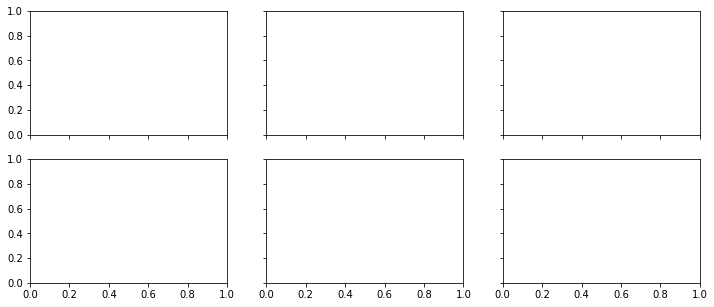

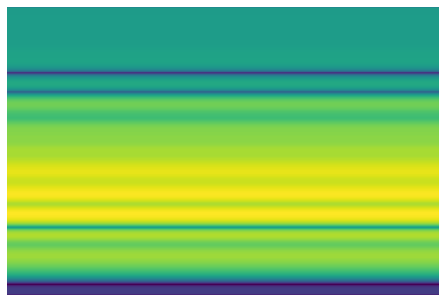

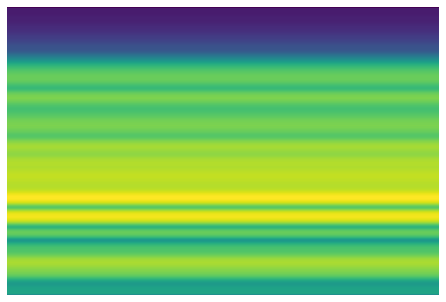

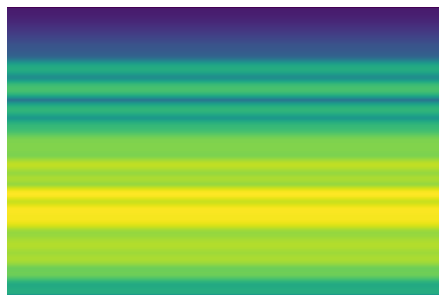

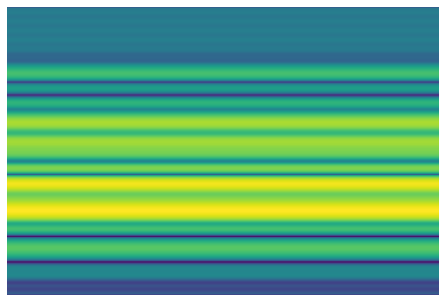

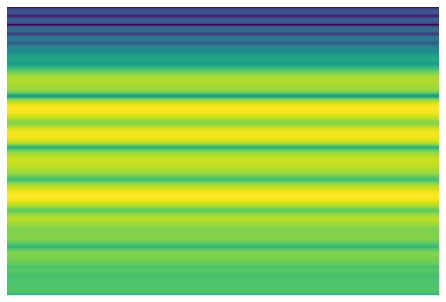

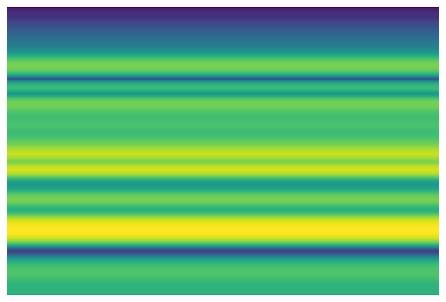

In [ ]:
plot_cwt_coeffs_per_label(X_train, train_labels_indices, LABEL_NEWS, signal, sample, scales, wavelet)

In [ ]:
pywt.wavelist()

In [ ]:
import tensorflow as tf
import numpy as np
import pywt
import matplotlib.pyplot as plt 

In [ ]:
file = np.load("/content/CWRU_48k_load_1_CNN_data.npz")
file.files

['data', 'labels']

In [ ]:
raw_data = file["data"]
raw_data.shape

(4600, 32, 32)

In [ ]:
raw_data = raw_data.reshape(-1, 1024)
raw_data.shape

(4600, 1024)

In [ ]:
wavelet_data = np.repeat(np.nan, repeats = 460 * 10 * 32 * 32).reshape(-1, 32, 32)
for i in range(raw_data.shape[0]):
    segment = raw_data[i, :]
    coefs, _ = pywt.cwt(segment, np.arange(start = 1, stop = 2049, step = 32), "morl")
    wavelet_data[i, :, :] = tf.reshape(tf.image.resize(coefs.reshape((64, 1024, 1)), (32, 32)), (32, 32))
    if (i % 100) == 0 and (i != 0):
        print(f"{i} segments processed.")

In [ ]:
wavelet_data.shape

(4600, 32, 32)

In [ ]:
from PIL import Image

In [ ]:
raw_data.shape[0]

4600

In [ ]:
for i in range(raw_data.shape[0]):
  img = Image.fromarray(wavelet_data[i, :, :], 'RGB')
  img.show()

In [ ]:
img = Image.fromarray(wavelet_data[1, :, :], 'RGB')

In [ ]:
img.save('my_1.png')
img.show()

In [ ]:
train_data.shape

(3600, 32, 32)

0
1
2
3
4
5
6
7
8
9


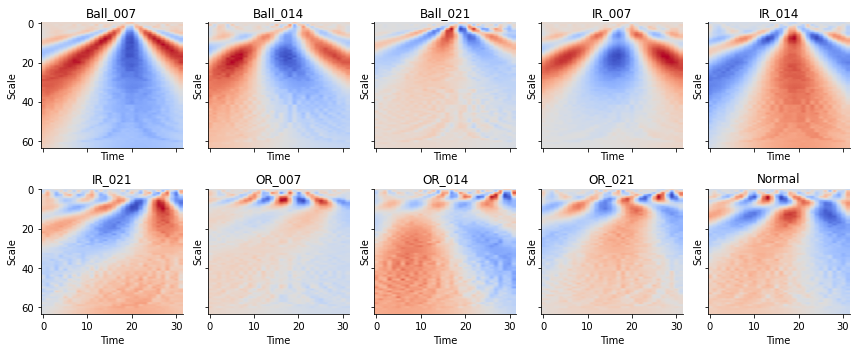

In [ ]:
import matplotlib.pyplot as plt
# for i,ax in enumerate(axes.flat):
#   img = Image.fromarray(wavelet_data[i, :, :], 'RGB')
#   ax.imshow(img, cmap = 'coolwarm', aspect = 'auto')

fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(12, 5))
for i, ax, name in zip(range(0, 3600), axs.flat, fault_types):
  # apply PyWavelets continuous wavelet transformation function
  coeffs, freqa = pywt.cwt(train_data[i, :, 1], scales, wavelet = wavelet)
  print(i)
  # create scalogram
  ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
  ax.set_title(name)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.set_ylabel('Scale')
  ax.set_xlabel('Time')
  
plt.tight_layout()

In [ ]:
fault_types = ['Ball_007', 'Ball_014', 'Ball_021', 'IR_007', 'IR_014', 'IR_021', 'OR_007','OR_014', 'OR_021', 'Normal']
labels = np.repeat(fault_types, 460)

In [ ]:
# Clone the repo and run current notebook.
file = np.load('/content/CWRU_48k_load_1_CNN_wavelet_morlet_data.npz')
print(file.files)

['data', 'labels']


In [ ]:
data = file['data']
labels = file['labels']
print(data.shape, labels.shape)

(4600, 32, 32) (4600,)


In [ ]:
category_labels = np.unique(labels)
print(category_labels)

['Ball_007' 'Ball_014' 'Ball_021' 'IR_007' 'IR_014' 'IR_021' 'Normal'
 'OR_007' 'OR_014' 'OR_021']


In [ ]:
import pandas as pd

In [ ]:
labels = pd.Categorical(labels, categories = category_labels).codes

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 1000, random_state = 829,
                                                                   stratify = labels)

In [ ]:
fault_types = ['Ball_007', 'Ball_014', 'Ball_021', 'IR_007', 'IR_014', 'IR_021', 'OR_007','OR_014', 'OR_021', 'Normal']
_train_labels_indices = split_indices_per_label(train_labels)

TypeError: ignored

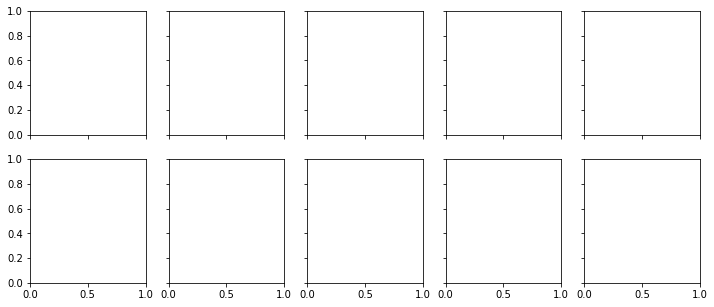

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(12, 5))

for i in range(raw_data.shape[0]):
    segment = raw_data[i, :]
    coefs, _ = pywt.cwt(segment, np.arange(start = 1, stop = 2049, step = 32), "morl")

    axs.
for ax, indices, name in zip(axs.flat, _train_labels_indices, fault_types):
  # apply PyWavelets continuous wavelet transformation function
  coeffs, freqa = pywt.cwt(train_data[:,:, :], scales, wavelet = wavelet)

  # create scalogram
  ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
  ax.set_title(name)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.set_ylabel('Scale')
  ax.set_xlabel('Time')
  
plt.tight_layout()